# Asian option pricing

## Bogumił Kamiński

We start by giving a definition of an Asian option we consider. The payoff of such an option depends on some underlying financial instrument. Assume that this underlying instrument is a stock. We observe the price of this stock over some period of time. The Asian option gives an investor a payoff if the average price of the stock is greater than a value called strike price. In such a case the payoff of the Asian option is equal to the mean price of the stock minus the strike price. Now let me formally define the way the payoff is computed.

Assume there is a stock traded on a market. By X(t) denote its price at time t. For simplicity, assume that we are currently at time t=0 and we know the price of the stock that is X(0). We are interested in the average price of this stock in the period from t=0 to t=T. We take that during this period the stock changes its price m times. Therefore, we will see its price at times: 0, T/m, 2T/m, ..., (m-2)T/m, (m-1)T/m, T. Denote the average price of the stock over these m+1 points in time in time by Y.

The Asian option we consider has the following rule of its valuation. At time T we compute the average price of the stock Y. If this value is greater than some value K (called the strike price) then we get Y-K payoff; otherwise we get no payoff. More formally, our payoff is max(Y-K, 0).

Our task is to compute the value of the Asian option at time 0. Note that in this time we do not know Y. What is then a fair value of our Asian option? Imagine that we could buy such an option many times and observe the evolution of the prices of the stock underlying our option. The value of our option is defined to be the average payoff we could expect in such experiment. Formally, using the language of probability theory, we say that we want to compute the expected value of our payoff, that is E(max(Y-K, 0)). However, there is one additional factor we need to consider. Since the payoff is collected at time T, and we are at time 0 we need to discount it. Assume that r is risk-free interest rate, and we use continuous compounding. Therefore, we need to multiply the expected value of the payoff by discount factor exp(-rT). In summary, the value of the option at time 0 is exp(-rT)·E(max(Y-K, 0)).

The challenge of computing the requested value is that at time 0 the value of Y is unknown. What we will assume is that the price of the stock in the period between 0 and T follows Geometric Brownian Motion (GBM). This stochastic process is often used to model prices of financial assets.

We assume that between two consecutive points in time the log-return of stock price log(X(t2)/X(t1)) follows a normal distribution with mean (r-s2/2)(t2-t1) and standard deviation s√(t2-t1).

In a single step of Monte Carlo simulation we need to compute the payoff of our Asian option for a single realization of the GBM process. Therefore, we need to perform the following operations:

In Monte Carlo simulation we repeat this single step of the process independently many times. Denote the number of repetitions we perform this single step by n. We thus will collect n values V(1), V(2), ..., V(n-1), V(n). The mean of these values approximates the value of our Asian option exp(-rT)·E(max(Y-K, 0)). However, since the process we have described above is randomized this value is not exact. In such situations we usually want to quantify this uncertainty somehow. We will therefore compute the 95% confidence interval of our Asian option price.

In [1]:
using DataFrames

In [2]:
using Plots

In [3]:
using Random

In [4]:
using Statistics

First define sampler of a single path of asset price:

In [5]:
function payoff_asian_sample(T, X0, K, r, s, m)::Float64
    X = X0
    sumX = X
    d = T / m
    for i in 1:m
        X *= exp((r - s^2 / 2) * d + s * sqrt(d) * randn())
        sumX += X
    end
    Y = sumX / (m + 1)
    return exp(-r * T) * max(Y - K, 0)
end

payoff_asian_sample (generic function with 1 method)

In [6]:
payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200),
payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200),
payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200),
payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200),
payoff_asian_sample(1.0, 50.0, 55.0, 0.05, 0.3, 200)

(0.0, 0.0, 6.3192461795685775, 0.0, 13.2803115668857)

Now implement a function performing valuation of the asset. Note that we parameterize it by running time `max_time`.

In [7]:
function asian_value(T, X0, K, r, s, m, max_time)
    result = Float64[]
    start_time = time()
    while time() - start_time < max_time
        append!(result, [payoff_asian_sample(T, X0, K, r, s, m) for _ in 1:10_000])
    end
    n = length(result)
    mv = mean(result)
    sdv = std(result)
    lo95 = mv - 1.96 * sdv / sqrt(n)
    hi95 = mv + 1.96 * sdv / sqrt(n)
    zero = mean(==(0), result)
    return (; n, mv, lo95, hi95, zero)
end

asian_value (generic function with 1 method)

In [8]:
@time asian_value(1.0, 50.0, 55.0, 0.05, 0.3, 200, 0.25),
@time asian_value(1.0, 50.0, 55.0, 0.05, 0.3, 200, 0.25),
@time asian_value(1.0, 50.0, 55.0, 0.05, 0.3, 200, 0.25)

  0.258975 seconds (38 allocations: 4.175 MiB, 4.55% gc time)
  0.532297 seconds (8.37 k allocations: 9.039 MiB, 2.21% gc time, 2.09% compilation time)
  0.785385 seconds (8.47 k allocations: 13.218 MiB, 1.50% gc time, 1.78% compilation time)


((n = 160000, mv = 2.0387336266790417, lo95 = 2.0167827817431667, hi95 = 2.0606844716149166, zero = 0.6925125), ((n = 170000, mv = 2.0402190277568253, lo95 = 2.018889948257707, hi95 = 2.0615481072559434, zero = 0.6938058823529412), (n = 160000, mv = 2.033280080148206, lo95 = 2.0113315332991997, hi95 = 2.055228626997212, zero = 0.69436875)))

We are ready to run the experiments an collect their results:

In [9]:
df = DataFrame(K=30:2:80)

Row,K
,Int64
1,30
2,32
3,34
4,36
5,38
6,40
7,42
8,44
9,46


Since `asian_value` returns a `NamedTuple` we can expand it to multiple columns using `AsTable` target in `transform!`.

In [10]:
transform!(df, "K" => ByRow(K -> asian_value(1.0, 50.0, K, 0.05, 0.3, 200, 0.25)) => AsTable)

Row,K,n,mv,lo95,hi95,zero
,Int64,Int64,Float64,Float64,Float64,Float64
1,30,30000,20.1811,20.084,20.2783,0.000866667
2,32,100000,18.3372,18.2842,18.3902,0.00265
3,34,100000,16.4231,16.3701,16.4762,0.00883
4,36,100000,14.5662,14.5136,14.6188,0.02243
5,38,90000,12.7011,12.646,12.7561,0.0476222
6,40,100000,10.9472,10.8963,10.9981,0.08601
7,42,100000,9.2189,9.16957,9.26823,0.14311
8,44,110000,7.69613,7.65127,7.74098,0.213555
9,46,90000,6.26849,6.22217,6.31482,0.299489


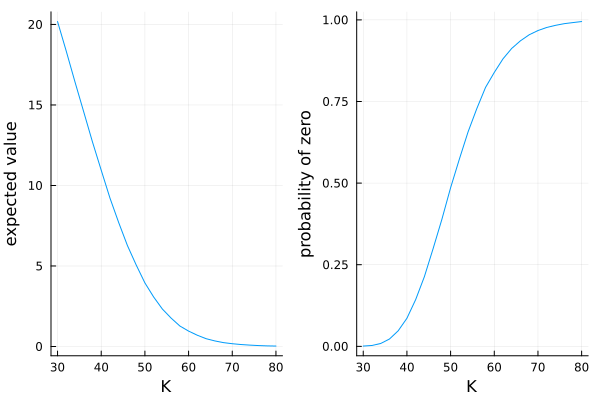

In [11]:
plot(plot(df.K, df.mv; legend=false,
          xlabel="K", ylabel="expected value"),
     plot(df.K, df.zero; legend=false,
          xlabel="K", ylabel="probability of zero"))